In [3]:
!pip install sklearn2pmml && pip install pypmml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.9 MB/s 
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.86.0-py3-none-any.whl size=6334248 sha256=92c0d47c06f31e0982d5b9e5523bedb4c518cfb54b58dc0d2363cd9035768227
  Stored in directory: /root/.cache/pip/wheels/66/1e/30/394b0b05900c577988fa2ed7c79fadee2fe40587a96ba49d49
Successfully built sklearn2pmml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.0 MB 5.1 MB/s 
     |████████████████████████████████| 200 kB 37.5 MB/s 
  Created wheel for pypmml: filename=pypmml-0.9.16-py3-none-any.whl size=15047704 sha256=16ca891b4232c4b9ed5130fdafd76afd65207edf26feb3268157e3a2bf5d5060
  Stored in directory: /root/.cache/pip/wheels/dc/54/78/12cc7079840b8ca2d1ee700de2d9fc3930380ee6e1c520d73b
Successfully built pypmml


In [4]:
import numpy as np
import pandas as pd

from sklearn.metrics import log_loss

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

from pypmml import Model

######

from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

In [5]:
df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')

In [6]:
df = df[['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'alone', 'survived']]
df['sex'] = (df['sex'] == 'male').astype(int)
df['alone'] = (df['alone'] == 'y').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
features = ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'alone']
target = 'survived'

#Separação de Conjunto de Teste

In [8]:
split = ShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
split.get_n_splits(df)

for train_index, test_index in split.split(df):
    index_treino = train_index
    index_teste = test_index

In [9]:
df_teste = df.loc[index_teste, :].reset_index(drop = True).copy()
df = df.loc[index_treino, :].reset_index(drop = True).copy()

#Separação dos Conjuntos de Treino e Validação

In [10]:
split = ShuffleSplit(n_splits = 10, test_size = 0.25, random_state = 42)
split.get_n_splits(df)
lista_trainval = []
for train_index, val_index in split.split(df):
    lista_trainval.append((train_index, val_index))

#Treinamento com Validação

In [11]:
def treino_arvore(X_train, y_train, X_val, y_val, depth):
    clf = DecisionTreeClassifier(max_depth = depth, criterion = 'entropy', random_state = 42)
    clf_vot = VotingClassifier(estimators = [('est', clf)], voting = 'soft')
    clf_vot.fit(X_train, y_train)
    return log_loss(y_train, clf_vot.predict_proba(X_train)[:, 1]), log_loss(y_val, clf_vot.predict_proba(X_val)[:, 1]), clf_vot

def plot_curva_vies_variancia(v_pos, loss_train, loss_val):
    ind_min = np.argmin(loss_val)
    best_pos = v_pos[ind_min]
    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = (10, 6))
        ax.plot(v_pos, loss_train, color = paleta_cores[0], label = 'Treino')
        ax.scatter(best_pos, loss_train[ind_min], color = paleta_cores[0])
        ax.plot(v_pos, loss_val, color = paleta_cores[1], label = f'Validação ({str(best_pos)})')
        ax.scatter(best_pos, loss_val[ind_min], color = paleta_cores[1])
        ax.set_xlabel('Profundidade')
        ax.set_ylabel('Loss')
        ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
        plt.show()

def treino_com_validacao(X_train, y_train, X_val, y_val, max_depth = 10):
    v_depth = np.arange(1, max_depth+1)
    retorno = [treino_arvore(X_train, y_train, X_val, y_val, depth) for depth in v_depth]
    loss_train = np.array([v[0] for v in retorno])
    loss_val = np.array([v[1] for v in retorno])
    best_depth = v_depth[np.argmin(loss_val)]

    plot_curva_vies_variancia(v_depth, loss_train, loss_val)
    #_, _, clf = treino_arvore(X_train, y_train, X_val, y_val, best_depth)

    #return clf
    return best_depth

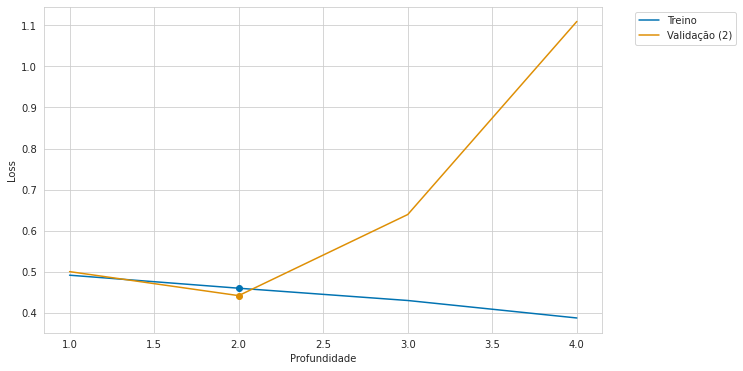

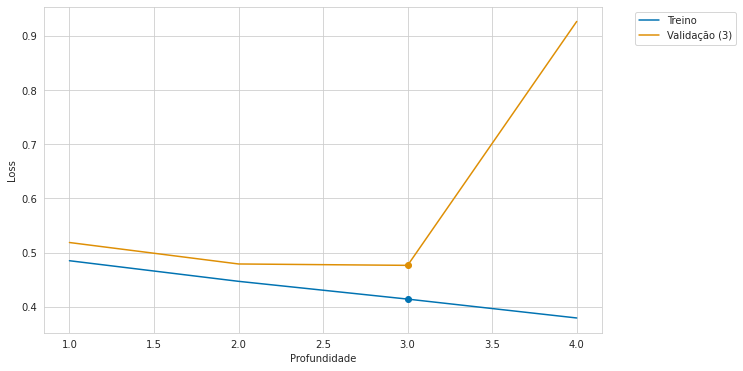

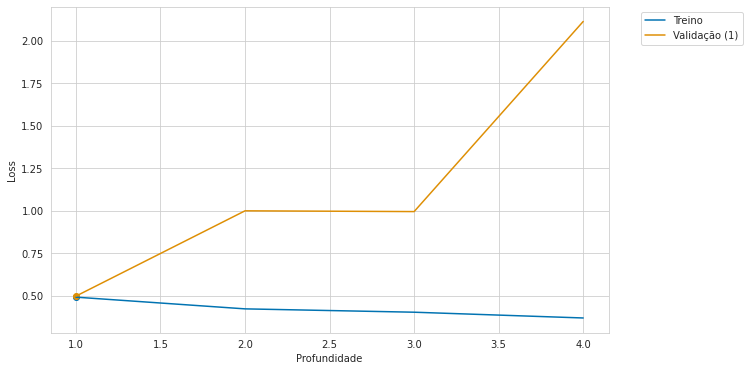

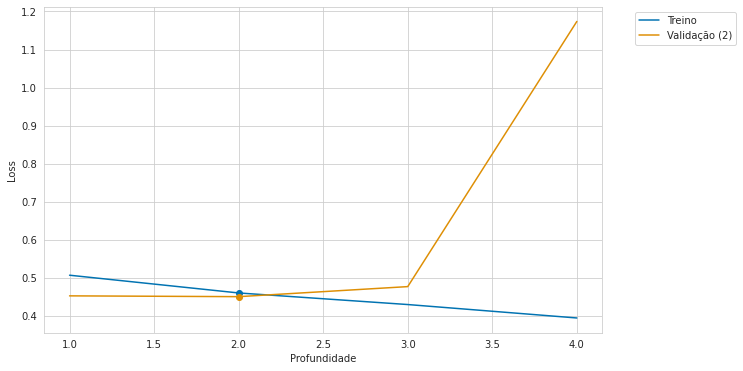

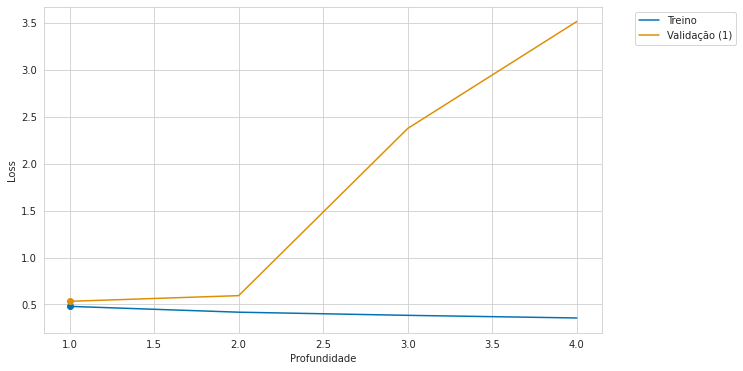

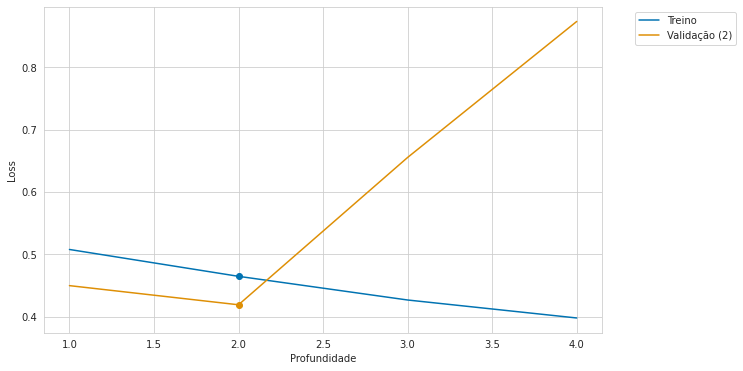

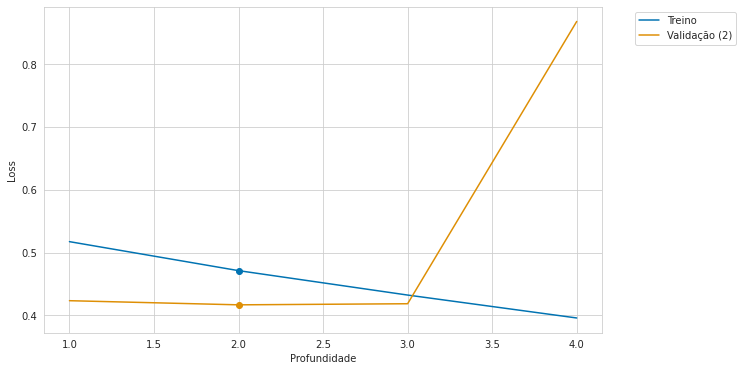

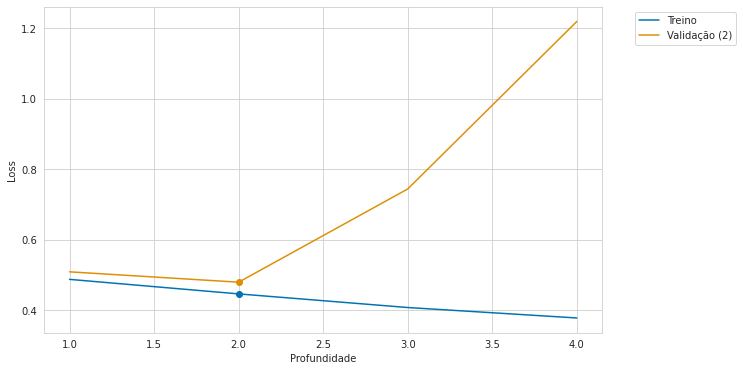

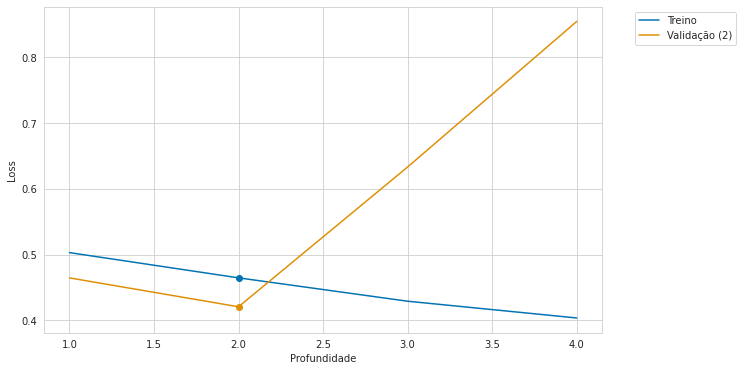

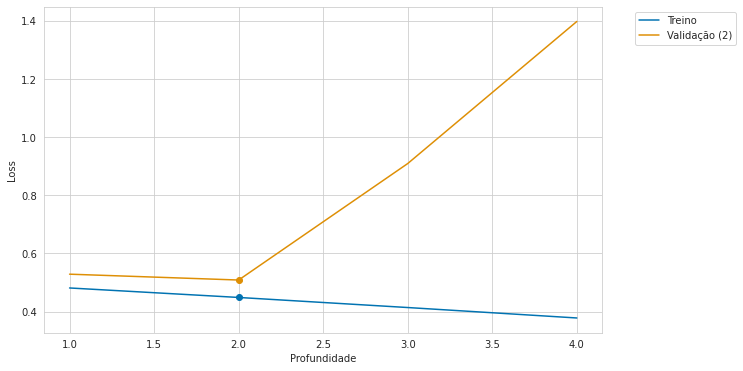

In [12]:
lista_best_depth = []
for i in range(0, len(lista_trainval)):
    index_train = lista_trainval[i][0]
    index_val = lista_trainval[i][1]

    best_depth = treino_com_validacao(df.loc[index_train, features], df.loc[index_train, target],
                                      df.loc[index_val, features], df.loc[index_val, target],
                                      max_depth = 4)
    lista_best_depth.append(best_depth)

In [13]:
uniques, qtds = np.unique(lista_best_depth, return_counts = True)
best_depth = uniques[np.argmax(qtds)]

_, _, clf = treino_arvore(df[features], df[target], df[features], df[target], best_depth)

In [14]:
clf.predict_proba(df[features])

array([[0.29850746, 0.70149254],
       [0.88030888, 0.11969112],
       [0.66055046, 0.33944954],
       ...,
       [0.88030888, 0.11969112],
       [0.03225806, 0.96774194],
       [0.88030888, 0.11969112]])

# Converte Para PMML

In [15]:
pipeline = PMMLPipeline([
	("classifier", VotingClassifier(estimators = [('ens0', clone(clf.estimators_[0]))], voting = 'soft'))
])
pipeline.fit(df[features].iloc[:100], df[target].iloc[:100])

clf_vot = pipeline.steps[0][1]
clf_vot.estimators_[0] = clf.estimators_[0]

In [16]:
pipeline.predict_proba(df[features])

array([[0.29850746, 0.70149254],
       [0.88030888, 0.11969112],
       [0.66055046, 0.33944954],
       ...,
       [0.88030888, 0.11969112],
       [0.03225806, 0.96774194],
       [0.88030888, 0.11969112]])

In [17]:
sklearn2pmml(pipeline, "DecisionTree.pmml", with_repr = True)

# Executa PMML

In [18]:
model = Model.fromFile('DecisionTree.pmml')

In [19]:
exemplo = df[features].to_dict(orient = 'records')[0]
print(exemplo)
result = model.predict(exemplo)
print(result)
print(pipeline.predict_proba(df[features].iloc[[0]]))

{'sex': 0, 'age': 29.0, 'n_siblings_spouses': 1, 'parch': 0, 'fare': 26.0, 'alone': 0}
{'probability(1)': 0.7014925373134329, 'probability(0)': 0.29850746268656714}
[[0.29850746 0.70149254]]


In [20]:
model.predict(df[features])

,probability(0),probability(1)
0,0.298507,0.701493
1,0.880309,0.119691
2,0.660550,0.339450
3,0.660550,0.339450
4,0.880309,0.119691
...,...,...
559,0.660550,0.339450
560,0.660550,0.339450
561,0.880309,0.119691
562,0.032258,0.967742


# Avaliação do Classificador

In [21]:
ks_2samp(pipeline.predict_proba(df_teste.loc[df_teste[target] == 0, features])[:, 1],
         pipeline.predict_proba(df_teste.loc[df_teste[target] == 1, features])[:, 1])

KstestResult(statistic=0.5714285714285714, pvalue=0.0001242415894209259)